In [ ]:
# Using Pytorcj
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from matplotlib import pyplot as plt

device = torch.device('cpu') # cuda

**TASK 1 - CLASSIFICATION WITH CIFAR 10** 


In [ ]:
# Note: Pytorch class torchvision.datasets.CIFAR10 will download the dataset during initial call.

kwargs = {'num_workers': 1, 'pin_memory': True} if device==torch.device('cuda') else {}
train_loader = torch.utils.data.DataLoader(datasets.CIFAR10('../data', train=True, download=True,
                                                                    transform=transforms.Compose([transforms.ToTensor(),
                                                                                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))       # Calculate mean and standard deviation of dataset
                                                                                      ])), batch_size=512, shuffle=True, **kwargs)

len(train_loader)


Extracting ../data/cifar-10-python.tar.gz to ../data


98

In [ ]:
for batch_idx, (data, target) in enumerate(train_loader):
    print(f"batch_idx: {batch_idx}")
    print(f"data shape: {data.shape}")
    print(f"target shape: {target.shape}")

batch_idx: 0
data shape: torch.Size([512, 3, 32, 32])
target shape: torch.Size([512])
batch_idx: 1
data shape: torch.Size([512, 3, 32, 32])
target shape: torch.Size([512])
batch_idx: 2
data shape: torch.Size([512, 3, 32, 32])
target shape: torch.Size([512])
batch_idx: 3
data shape: torch.Size([512, 3, 32, 32])
target shape: torch.Size([512])
batch_idx: 4
data shape: torch.Size([512, 3, 32, 32])
target shape: torch.Size([512])
batch_idx: 5
data shape: torch.Size([512, 3, 32, 32])
target shape: torch.Size([512])
batch_idx: 6
data shape: torch.Size([512, 3, 32, 32])
target shape: torch.Size([512])
batch_idx: 7
data shape: torch.Size([512, 3, 32, 32])
target shape: torch.Size([512])
batch_idx: 8
data shape: torch.Size([512, 3, 32, 32])
target shape: torch.Size([512])
batch_idx: 9
data shape: torch.Size([512, 3, 32, 32])
target shape: torch.Size([512])
batch_idx: 10
data shape: torch.Size([512, 3, 32, 32])
target shape: torch.Size([512])
batch_idx: 11
data shape: torch.Size([512, 3, 32, 32]

In [ ]:
it = iter(train_loader)
first = next(it)
second = next(it)
print(f"Length of it: {len(it)}")
print(f"Length of first: {len(first)}")
print(f"Length of second: {len(second)}")

Length of it: 98
Length of first: 2
Length of second: 2


In [ ]:
print(f"Shape of first[0]: {first[0].shape}")
print(f"Shape of first[1]: {first[1].shape}")
print(f"Shape of first[0] min value: {first[0].min()}")
print(f"Shape of first[0] max value: {first[0].max()}")
print(f"List of unique numerical labels: {first[1].unique()}")

Shape of first[0]: torch.Size([512, 3, 32, 32])
Shape of first[1]: torch.Size([512])
Shape of first[0] min value: -2.429065704345703
Shape of first[0] max value: 2.7537312507629395
List of unique numerical labels: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


In [ ]:
print(f"Shape of second[0]: {second[0].shape}")
print(f"Shape of second[1]: {second[1].shape}")
print(f"Shape of second[0] min value: {second[0].min()}")
print(f"Shape of second[0] max value: {second[0].max()}")
print(f"List of unique numerical labels: {second[1].unique()}")

Shape of second[0]: torch.Size([512, 3, 32, 32])
Shape of second[1]: torch.Size([512])
Shape of second[0] min value: -2.429065704345703
Shape of second[0] max value: 2.7537312507629395
List of unique numerical labels: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


Thus, we have 98 batches of 512 images of dimensions 32 x 32 and 3 channels. Each image has a numerical integer label from 0 to 9.

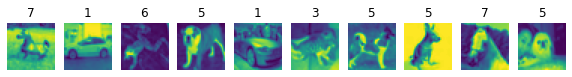

In [ ]:
data,target=first
plt.figure(figsize=(10, 100))
for i in range(10):
  plt.subplot(1, 10, i+1)
  plt.imshow(data[i, 0].cpu())
  plt.axis('off')
  plt.title(target[i].item())

plt.show()

We will now train our model with two ways: a. without residual connection, b. with residual connection

**A. Without Residual Connection**

Residual connections are the same thing as 'skip connections'. They are used to allow gradients to flow through a network directly, without passing through non-linear activation functions. 

In [ ]:
class Net(nn.Module): 
  def __init__(self):
    super(Net, self).__init__()

    # x: 32 x 32 x 3 channels
    self.cv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=0, dilation=1) # 32 filters: 3 x 3 x 3 channels
    # (input size + (2 x padding) - dilation x (filterize -1) - 1)/stride + 1
    # 30 x 30 x 32 channels  # (32 + (2 x 0) - 1 x (3 -1) - 1)/1 + 1 # (32 - 2 - 1)/1 + 1

    self.cv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0, dilation=1) # 64 filters: 3 x 3 x 32 channels
    # 28 x 28 x 64 channels (output_dim=30-3+1)

    self.fc1 = nn.Linear(in_features=50176, out_features=128) # 50176 = 28 x 28 x 64
    self.fc2 = nn.Linear(in_features=128, out_features=10)
    self.sm1 = nn.LogSoftmax(dim=1) # gives you a probability between 0 and 1

  def forward(self, x): 
    out = F.relu(self.cv1(x))   # Conv Layer 1 + ReLU  # 30 x 30 x 32 channels
    out = F.relu(self.cv2(out)) # Conv Layer 2 + ReLU # 28 x 28 x 64 channels 

    out = out.view(out.size(0), -1) # Reshape from 28 x 28 x 64 to  50176 x 1

    out = F.relu(self.fc1(out)) # Fully Connected Layer 1 + ReLu # 128 x 1
    out = self.fc2(out) # Fully Connected Layer 2 # 128 x 1
    out = self.sm1(out) # Log Softmax Activation Function
    
    return out
      
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001) 
lossfun = nn.NLLLoss() # maximum likelihood estimation; other options: MSE(), CE()


Training our model. NOTE: We only define our train function here once and it will be reused for the option b. 

In [ ]:
def train(model, train_loader, epochs): 
  model.train() 

  epoch_loss = []
  epoch_accu = []

  for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):

      data, target = data.to(device), target.to(device)

      output = model(data)

      loss = lossfun(output, target)

      optimizer.zero_grad()
      loss.backward()

      optimizer.step()

      ##### Bookkeeping

      accuracy = (output.argmax(-1)==target).float().mean() # 512 x 1 vector where each entry is whether or not the highest 
        # probability label output by the model corresponds to the actual target label
      epoch_loss.append(loss.item())
      epoch_accu.append(accuracy.item())
        # accuracy: 1%
        # accuracy: 7%
        # accuracy: 10%
        # accuracy: 15%
    # accuracy.item([1,7,10,15])

      if batch_idx % 50 == 0: 
        print('Train Epoch: {}[{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.2f}'.format(
            epoch+1, batch_idx*len(data), len(train_loader.dataset), 
            100. * batch_idx / len(train_loader), loss.item(), accuracy.item()))
      
      print('Train Epoch: {}\tAverage Loss: {:.6f}\tAverage Accuracy: {:.2f}'.format(
            epoch+1, sum(epoch_loss)/len(epoch_loss), sum(epoch_accu)/len(epoch_accu)))

  torch.save(model.state_dict(), 'cifar10_cnn.pt')

  return epoch_loss, epoch_accu

In [ ]:
epoch_loss, epoch_accu = train(model, train_loader, epochs=1)

Train Epoch: 1[0/50000 (0%)]	Loss: 1.330685	Accuracy: 0.53
Train Epoch: 1	Average Loss: 1.330685	Average Accuracy: 0.53
Train Epoch: 1	Average Loss: 1.289409	Average Accuracy: 0.55
Train Epoch: 1	Average Loss: 1.267436	Average Accuracy: 0.55
Train Epoch: 1	Average Loss: 1.258078	Average Accuracy: 0.56
Train Epoch: 1	Average Loss: 1.250166	Average Accuracy: 0.56
Train Epoch: 1	Average Loss: 1.234782	Average Accuracy: 0.56
Train Epoch: 1	Average Loss: 1.238164	Average Accuracy: 0.57
Train Epoch: 1	Average Loss: 1.245969	Average Accuracy: 0.56
Train Epoch: 1	Average Loss: 1.236687	Average Accuracy: 0.57
Train Epoch: 1	Average Loss: 1.246104	Average Accuracy: 0.57
Train Epoch: 1	Average Loss: 1.244100	Average Accuracy: 0.56
Train Epoch: 1	Average Loss: 1.234375	Average Accuracy: 0.57
Train Epoch: 1	Average Loss: 1.228497	Average Accuracy: 0.57
Train Epoch: 1	Average Loss: 1.228022	Average Accuracy: 0.57
Train Epoch: 1	Average Loss: 1.225020	Average Accuracy: 0.57
Train Epoch: 1	Average Los

PLOT THE LOSS FUNCTION

NameError: ignored

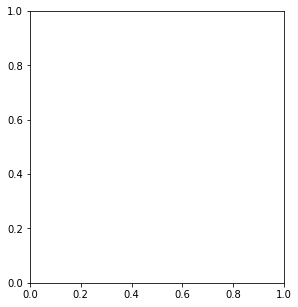

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)

plt.plot(epoch_loss)
plt.xlabel('batch')
plt.ylabel('loss')

plt.subplot(1, 2, 2)
plt.plot(epoch_accu)
plt.xlabel('batch')
plt.ylabel('accuracy')

TEST our model

In [ ]:
# Define the test set 
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])),
    batch_size=512, shuffle=True, **kwargs)

In [ ]:
# Define test function
def test(model, test_loader):
  model.eval() # put the model into the evaluation mod
  test_loss = 0
  test_accu = 0
  
  with torch.no_grad(): 

    for data, target in test_loader:
      data, target = data.to(device), target.to(device)

      output = model(data)

      ## Bookkeeping
      test_loss += F.nll_loss(output, target, reduction='sum').item()
      test_accu += (output.argmax(dim=-1)==target).float().sum().item()

    test_loss /= len(test_loader.dataset)
    test_accu /= len(test_loader.dataset)



    print('\nTest set: Average Loss: {:.4f}, Accuracy: {:.2f}\n'.format(test_loss, test_accu))
    
    return test_loss, test_accu

In [ ]:
test_loss, test_accu = test(model, test_loader)


Test set: Average Loss: 1.1017, Accuracy: 0.61



**B. WITH RESIDUAL CONNECTION**

DEFINE NEURAL NETWORK MODEL WITH RESIDUAL CONENCTION

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    # x: 32 x 32 x 3 channels
    self.cv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=0, dilation=1) # 32 filters: 3 x 3 x 3 channels
    # (input size + (2 x padding) - dilation x (filterize -1) - 1)/stride + 1
    # 30 x 30 x 32 channels  # (32 + (2 x 0) - 1 x (3 -1) - 1)/1 + 1 # (32 - 2 - 1)/1 + 1

    self.cv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0, dilation=1) # 64 filters: 3 x 3 x 32 channels
    # 28 x 28 x 64 channels (output_dim=30-3+1)

    # residual connection
        # input x: 32 x 32 x 3 channels
        # output resized to fit previous output: 28 x 28 x 64 
    self.shortcut = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5)

    self.fc1 = nn.Linear(in_features=50176, out_features=128) # 50176 = 28 x 28 x 64
    self.fc2 = nn.Linear(in_features=128, out_features=10)
    self.sm1 = nn.LogSoftmax(dim=1)

  def forward(self, x): 
    out = F.relu(self.cv1(x))   # Conv Layer 1 + ReLU  # 30 x 30 x 32 channels
    out = F.relu(self.cv2(out)) # Conv Layer 2 + ReLU # 28 x 28 x 64 channels 

    out = out.view(out.size(0), -1) # Reshape from 28 x 28 x 64 to  50176 x 1

    out = F.relu(self.fc1(out)) # Fully Connected Layer 1 + ReLu # 128 x 1
    out = self.fc2(out) # Fully Connected Layer 2 # 128 x 1
    out = self.sm1(out) # Log Softmax Activation Function
    
    return out

model_with_rc = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001) 
lossfun = nn.NLLLoss()

In [ ]:
epoch_loss2, epoch_accu2 = train(model_with_rc, train_loader, epochs=1)

Train Epoch: 1[0/50000 (0%)]	Loss: 2.306356	Accuracy: 0.09
Train Epoch: 1	Average Loss: 2.306356	Average Accuracy: 0.09
Train Epoch: 1	Average Loss: 2.307834	Average Accuracy: 0.09
Train Epoch: 1	Average Loss: 2.306959	Average Accuracy: 0.10
Train Epoch: 1	Average Loss: 2.306863	Average Accuracy: 0.10
Train Epoch: 1	Average Loss: 2.307017	Average Accuracy: 0.10
Train Epoch: 1	Average Loss: 2.307219	Average Accuracy: 0.10
Train Epoch: 1	Average Loss: 2.307111	Average Accuracy: 0.10
Train Epoch: 1	Average Loss: 2.307152	Average Accuracy: 0.10
Train Epoch: 1	Average Loss: 2.307177	Average Accuracy: 0.10
Train Epoch: 1	Average Loss: 2.307206	Average Accuracy: 0.10
Train Epoch: 1	Average Loss: 2.306945	Average Accuracy: 0.10
Train Epoch: 1	Average Loss: 2.307112	Average Accuracy: 0.10
Train Epoch: 1	Average Loss: 2.307198	Average Accuracy: 0.10
Train Epoch: 1	Average Loss: 2.307224	Average Accuracy: 0.10
Train Epoch: 1	Average Loss: 2.307367	Average Accuracy: 0.10
Train Epoch: 1	Average Los

In [ ]:
test_loss, test_accu = test(model_with_rc, test_loader)


Test set: Average Loss: 2.3083, Accuracy: 0.09



**TASK 2: AUTOENCODER CIFAR10**




In [ ]:
class Net_auto(nn.Module):
  def __init__(self):
    super(Net_auto,self).__init__()

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=0, dilation=1)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=0, dilation=1 )
    self.fc1 = nn.Linear(in_features=12544, out_features=256)
    self.fc2 = nn.Linear(in_features=256, out_features=12544)
    self.convT1 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=0)
    self.convT2 = nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=3, stride=1, padding=0)


  def encoder(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = torch.flatten(x, 1) # reshape from 14x14x64 to 12544x 1
    x = self.fc1(x)
    return x
  
  def decoder(self, x):
    x = self.conv2(x)
    x = x.view(x.size(0), 64, 14, 14) # fill x into shape 64x14x14 with all 0 entries 
    x = F.relu(x)
    x = self.convT1(x)
    x = self.relu(x)
    x = self.convT2(x)

    return torch.sigmoid(x)


  def forward(self, x):
    l = self.encoder(x)
    output = self.decoder(l)
    return output

model_auto = Net_auto().to(device)
optimizer_auto = optim.Adam(model_auto.parameters(),lr=0.0001)
lossfun_auto = nn.MSELoss()


In [ ]:
# Define the training load for Autocoder
kwargs = {'num_workers': 1, 'pin_memory': True} if device==torch.device('cuda') else {}
ae_train_loader = torch.utils.data.DataLoader(datasets.CIFAR10('../data', train=True, download=True,
                                                                    transform=transforms.Compose([transforms.ToTensor()      # Calculate mean and standard deviation of dataset
                                                                                      ])), batch_size=512, shuffle=True, **kwargs)

Files already downloaded and verified


In [ ]:
epochs = 5
epoch_loss_ae1 = 0

for epoch in range(epochs):
    
    # iterate through train dataset
    
    for batch_idx, (data, _) in enumerate(ae_train_loader):
        
        data = data.to(device)
        
        # get output
        output = model_auto(data)
        
        # compute loss function
        loss = lossfun_auto(output, data)
        
        # backward pass
        optimizer_ae1.zero_grad()
        loss.backward()
        
        # run optimizer 
        optimizer_auto.step()
        
        # bookkeeping
        epoch_loss_ae1 += loss.item() * data.size(0)
        
        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1, batch_idx * len(data), len(ae_train_loader.dataset),
                100. * batch_idx / len(ae_train_loader), loss.item()))
            
    print('Train Epoch: {}\tAverage Loss: {:.6f}'.format(
        epoch+1, epoch_loss_ae1/len(ae_train_loader.dataset)))
            
# save network
torch.save(model_auto.state_dict(), "mnist_ae.pt")

RuntimeError: ignored

Testing the autocoder

In [ ]:
ae_test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor()])),
    batch_size=512, shuffle=True, **kwargs)

In [ ]:
model_auto1.eval() 
test_loss_ae1 = 0

with torch.no_grad(): # no need to compute gradients; also saves time and memory
    
    # iterate through test set
    for data, _ in ae_test_loader:
        data = data.to(device)
        
        # forward pass
        output_ae1 = model_auto(data)
        
        # bookkeeping
        #test_loss_ae1 += nn.MSELoss(output_ae1, data, reduction='mean').item()*data.size(0)
        test_loss_ae1 += F.binary_cross_entropy(output_ae1, data, reduction='mean').item()*data.size(0)  # loss


test_loss_ae1 /= len(test_loader.dataset)

print('\nTest set: Average Loss: {:.4f}\n'.format(
    test_loss_ae1))

In [ ]:
plt.close('All')
plt.figure(figsize=(20,5))
for i in range(10):
    plt.subplot(2,10,i+1)
    plt.imshow(data[i,0].cpu())
    plt.axis('off')
    plt.subplot(2,10,10+i+1)
    plt.imshow(output_ae1[i,0].detach().cpu())
    plt.axis('off')
    
plt.show()